In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.leeway import Leeway
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [2]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})

object_type = 26  # Life-raft, no ballast

In [3]:
duration = timedelta(hours=144)                # 6 days
start_time = datetime(2023,3,7,3,12,8)
end_time = start_time + duration

In [4]:
# Set the desired grid size
grid_size_lon = 0.25  # Change this to your desired grid size
grid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(30, 34, grid_size_lon)
lat_bins = np.arange(-39, -37, grid_size_lat)

In [5]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [6]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 100) # Much coarser CCC
        lats[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 100)

# FWD

In [7]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd_0713mar_raft_capsize_nocurrent_t12s1.nc"

In [179]:
ofwd = Leeway(loglevel=50)
ofwd.add_reader([reader_wind])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')

ofwd.set_config('environment:constant:x_sea_water_velocity', 0)
ofwd.set_config('environment:constant:y_sea_water_velocity', 0)

ofwd.set_config('capsizing', True)
ofwd.set_config('capsizing:wind_threshold', 12)
ofwd.set_config('capsizing:wind_threshold_sigma', 1)
ofwd.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#ofwd.set_config('drift:horizontal_diffusivity', 20)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
ofwd.run(duration=duration, time_step=600, time_step_output=3600, outfile=outfile)

In [8]:
fwd = xr.open_dataset(outfile)

In [9]:
fwd

<xarray.Dataset> Size: 158MB
Dimensions:               (trajectory: 10500, time: 145)
Coordinates:
  * trajectory            (trajectory) int32 42kB 1 2 3 4 ... 10498 10499 10500
  * time                  (time) datetime64[ns] 1kB 2023-03-07T03:12:08 ... 2...
Data variables: (12/23)
    status                (trajectory, time) float64 12MB ...
    moving                (trajectory, time) float64 12MB ...
    age_seconds           (trajectory, time) float32 6MB ...
    origin_marker         (trajectory, time) float64 12MB ...
    lon                   (trajectory, time) float32 6MB ...
    lat                   (trajectory, time) float32 6MB ...
    ...                    ...
    current_drift_factor  (trajectory, time) float32 6MB ...
    x_wind                (trajectory, time) float32 6MB ...
    y_wind                (trajectory, time) float32 6MB ...
    x_sea_water_velocity  (trajectory, time) float32 6MB ...
    y_sea_water_velocity  (trajectory, time) float32 6MB ...
    land_binary_mask      (trajectory, time) float32 6MB ...
Attributes: (12/72)
    Conventions:                                       CF-1.6
    standard_name_vocabulary:                          CF-1.6
    featureType:                                       trajectory
    history:                                           Created 2024-05-31 17:...
    source:                                            Output from simulation...
    model_url:                                         https://github.com/Ope...
    ...                                                ...
    geospatial_lat_resolution:                         point
    geospatial_lon_min:                                0.0
    geospatial_lon_max:                                0.0
    geospatial_lon_units:                              degrees_east
    geospatial_lon_resolution:                         point
    runtime:                                           0:00:35.551077

In [10]:
fwd.isel(trajectory=0).x_sea_water_velocity.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
fwd.isel(trajectory=0).current_drift_factor.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

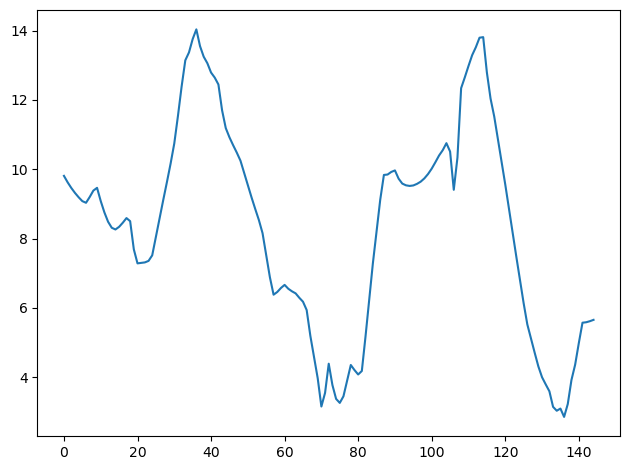

In [12]:
plt.plot(np.sqrt(np.square(fwd.isel(trajectory=5500).y_wind.values)+(np.square(fwd.isel(trajectory=5500).x_wind.values))))

In [12]:
len(fwd.trajectory)

10500

In [14]:
capsized = []
for i in range(len(fwd.trajectory)):
    capsized.append(fwd.isel(trajectory=i).capsized.values[-1])

In [15]:
np.count_nonzero(capsized)

10500

In [16]:
from matplotlib.colors import ListedColormap
ofwd.plot(color='capsized', cmap=ListedColormap(['black','red']), fast=True)

NameError: name 'ofwd' is not defined

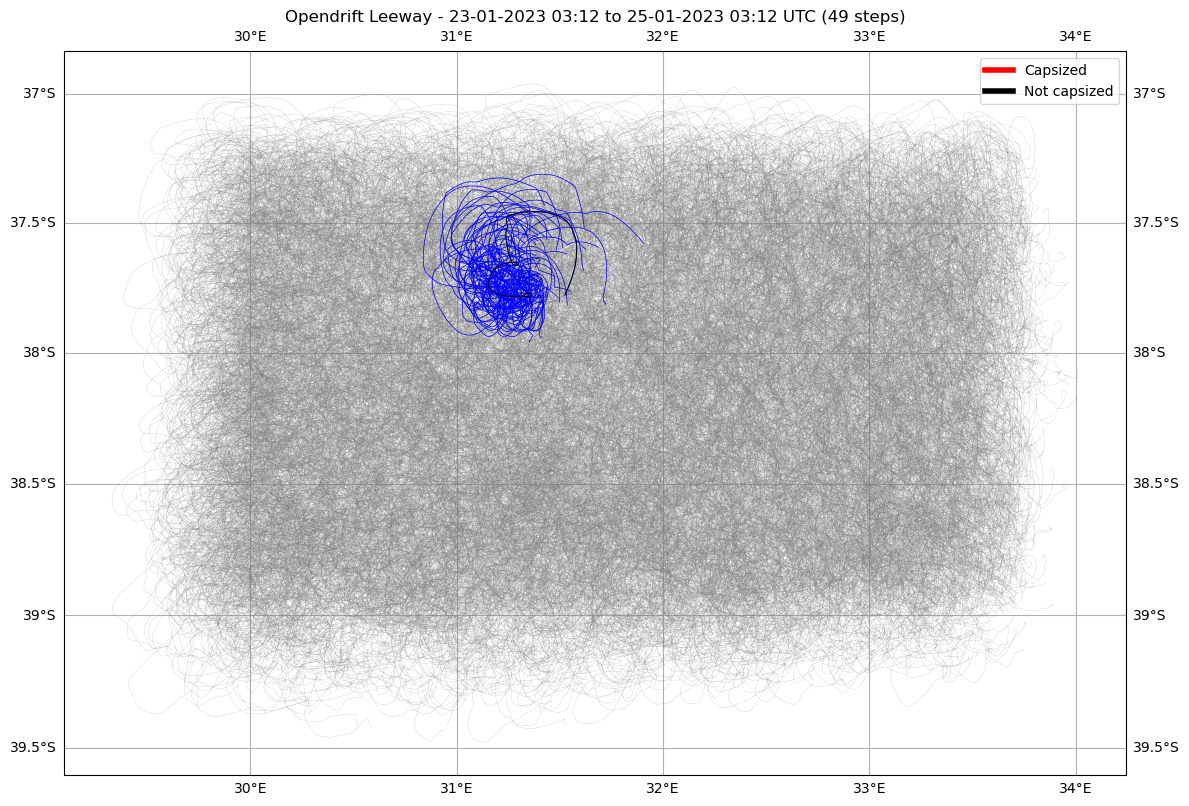

In [42]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits.values: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')

fwd.isel(trajectory=a).traj.plot(linewidth=0.7, color='black')


# for i in range(len(fwd.trajectory)):
#     if capsized[i]>0: 
#         fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
#     else: 
#         fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
ccrs.Geodetic()

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Capsized', 'Not capsized'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [18]:
## FORWARD ## 
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

## BACKWARDS

In [18]:
# orev = Leeway(loglevel=50)

In [19]:
# outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_2328feb_raft_capsize_nocurrent_v1.nc"

In [20]:
# lonend1 = np.array(lonend0)
# # latend1 = np.array(latend0)

In [21]:
# lonend = lonend1[~np.isnan(lonend0)]
# latend = latend1[~np.isnan(latend0)]

In [22]:
# orev = Leeway(loglevel=50)
# orev.add_reader([reader_wind])

# orev.set_config('drift:advection_scheme', 'runge-kutta4')
# orev.set_config('environment:constant:x_sea_water_velocity', 0)
# orev.set_config('environment:constant:y_sea_water_velocity', 0)

# orev.set_config('capsizing', True)
# orev.set_config('capsizing:wind_threshold', 15)
# orev.set_config('capsizing:wind_threshold_sigma', 5)
# orev.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

# #orev.set_config('drift:horizontal_diffusivity', 20)
# orev.seed_elements(lon=lonend, lat=latend, radius_type='uniform', time=end_time, object_type=object_type, capsized=1)
# orev.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd)

In [23]:
# bwd = xr.open_dataset(outfile_bwd)

In [24]:
# capsized_bwd = []
# for i in range(len(bwd.trajectory)):
#     capsized_bwd.append(bwd.isel(trajectory=i).capsized.values[-1])

In [25]:
# np.count_nonzero(capsized_bwd)

In [26]:
# len(bwd.trajectory)

In [27]:
### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(bwd.trajectory)):
#     if capsized_bwd[i]>0: 
#         bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
#     else: 
#         bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
# ccrs.Geodetic()

# custom_lines = [#Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 Line2D([0], [0], color='black', lw=4)]

# ax.legend(custom_lines, ['Capsized', 'Not capsized'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 25-01-2023 03:12 to 23-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Comparison

In [28]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

In [29]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='blue', marker='o')
#     fwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='lightblue', marker='o')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='red', marker='o')
#     bwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='pink', marker='o')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Picking one as 'truth'

In [41]:
n = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []

traj = np.arange(0,len(fwd.trajectory),1)

for i in range(1):
    a = np.random.choice(traj)
    a_traj.append(a)
    iloni = fwd.isel(trajectory=a).lon.values[-1]
    ilon.append(iloni)
    ilati = fwd.isel(trajectory=a).lat.values[-1]
    ilat.append(ilati)
    startloni = fwd.isel(trajectory=a).lon.values[0]
    startlon.append(startloni)
    startlati = fwd.isel(trajectory=a).lat.values[0]
    startlat.append(startlati)
    if iloni<1e10 and ilati<1e10:
        geod = pyproj.Geod(ellps='WGS84')
        on = np.ones(len(lonend0))
        dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, iloni*on, ilati*on)
        hits = pd.DataFrame(np.where(dist2incident<10000))
        lenhits = hits.shape[1]
        n.append(lenhits) 
        
        hit_start_lons = []
        hit_start_lats = []
        for m in range(lenhits):
            hit_start_lons.append(fwd.isel(trajectory=hits[m]).lon.values[-1][0])
            hit_start_lats.append(fwd.isel(trajectory=hits[m]).lat.values[-1][0])

In [133]:
a_traj

[4641]

In [19]:
a=4641

In [20]:
n = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []

for i in range(1):
    iloni = fwd.isel(trajectory=a).lon.values[-1]
    ilon.append(iloni)
    ilati = fwd.isel(trajectory=a).lat.values[-1]
    ilat.append(ilati)
    startloni = fwd.isel(trajectory=a).lon.values[0]
    startlon.append(startloni)
    startlati = fwd.isel(trajectory=a).lat.values[0]
    startlat.append(startlati)
    if iloni<1e10 and ilati<1e10:
        geod = pyproj.Geod(ellps='WGS84')
        on = np.ones(len(lonend0))
        dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, iloni*on, ilati*on)
        hits = pd.DataFrame(np.where(dist2incident<10000))
        lenhits = hits.shape[1]
        n.append(lenhits) 
        
        hit_start_lons = []
        hit_start_lats = []
        for m in range(lenhits):
            hit_start_lons.append(fwd.isel(trajectory=hits[m]).lon.values[-1][0])
            hit_start_lats.append(fwd.isel(trajectory=hits[m]).lat.values[-1][0])

In [21]:
fwd.isel(trajectory=a).capsized.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [22]:
hits.values[0]

array([3263, 3270, 3308, 3327, 3333, 3358, 3363, 3367, 3368, 3389, 3390,
       3394, 3913, 3919, 3955, 3957, 3967, 3968, 3972, 3975, 3983, 4002,
       4003, 4008, 4010, 4013, 4015, 4018, 4020, 4023, 4026, 4030, 4031,
       4034, 4041, 4045, 4052, 4056, 4058, 4064, 4069, 4070, 4072, 4078,
       4080, 4084, 4093, 4095, 4158, 4167, 4172, 4641, 4654, 4682, 4697,
       4752, 4764, 4765, 4766, 4768, 4787, 4848, 5402], dtype=int64)

In [23]:
xfwd = fwd.isel(trajectory=hits.values[0])

In [24]:
capsized_xfwd = []
for i in range(len(xfwd.trajectory)):
    capsized_xfwd.append(xfwd.isel(trajectory=i).capsized.values[-1])

In [25]:
np.count_nonzero(capsized_xfwd)

63

In [26]:
len(xfwd.trajectory)

63

In [27]:
xfwd.isel(trajectory=i).lon.values[0]

31.908344

In [28]:
xfwd.isel(trajectory=i).lat.values[0]

-37.582233

In [29]:
xlon = []       # lon for 'hits'
xlat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    xlon.append(xfwd.isel(trajectory=i).lon.values[0])
    xlat.append(xfwd.isel(trajectory=i).lat.values[0])

In [30]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(xlon, xlat, xlon_bins, xlat_bins)

NameError: name 'xlon_bins' is not defined

In [31]:
o_hit = opendrift.open(outfile, elements=hits.values[0])

13:40:47 DEBUG   opendrift.config:161: Adding 16 config items from __init__
13:40:47 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
13:40:47 DEBUG   opendrift.config:161: Adding 5 config items from __init__
13:40:47 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
13:40:47 DEBUG   opendrift.config:161: Adding 6 config items from leeway
13:40:47 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
13:40:47 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_fwd_0713mar_raft_capsize_nocurrent_t12s1.nc
13:40:50 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
13:40:50 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_wind -> None
13:40:50 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:fallback:x_wind -> None
13:40:50 DEBUG   opendrift.exp

13:41:02 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=False, lscale=None
13:41:03 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (30.438054656982427, 32.30834426879883, -38.158522796630855, -37.113106536865224)..
13:41:17 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (30.438054656982427, 32.30834426879883, -38.158522796630855, -37.113106536865224)..
13:41:19 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (30.438054656982427, 32.30834426879883, -38.158522796630855, -37.113106536865224)..


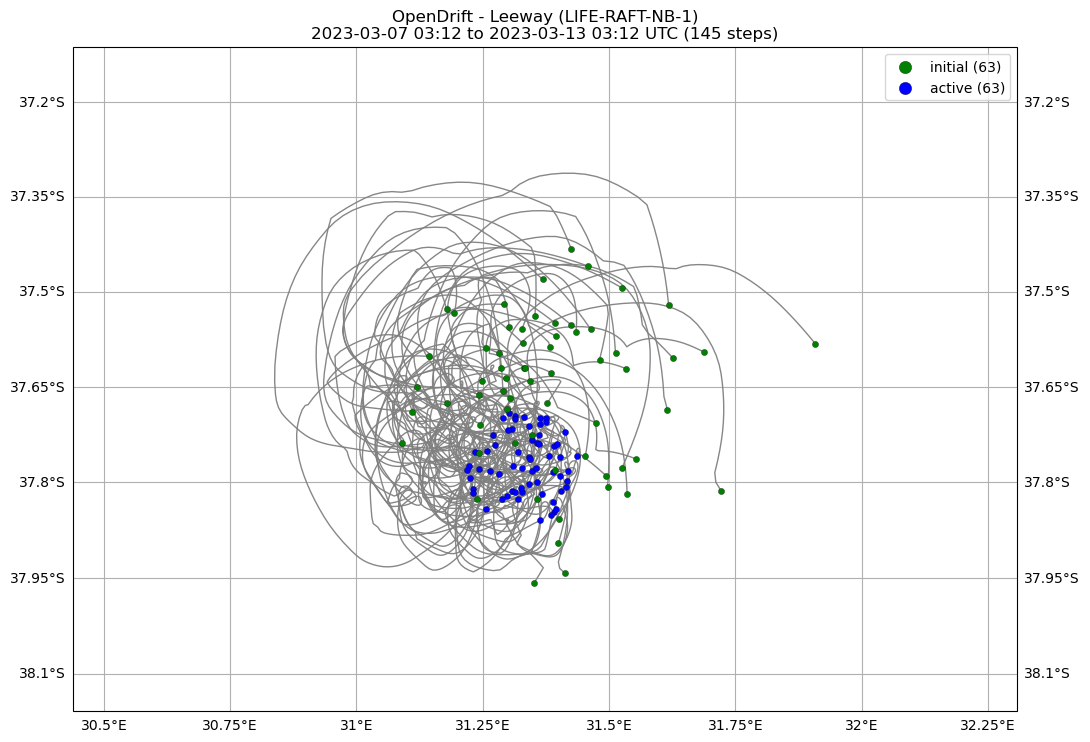

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-07 03:12 to 2023-03-13 03:12 UTC (145 steps)'}>,
 <Figure size 1100x776.423 with 1 Axes>)

In [32]:
o_hit.plot()

10:57:28 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:57:28 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


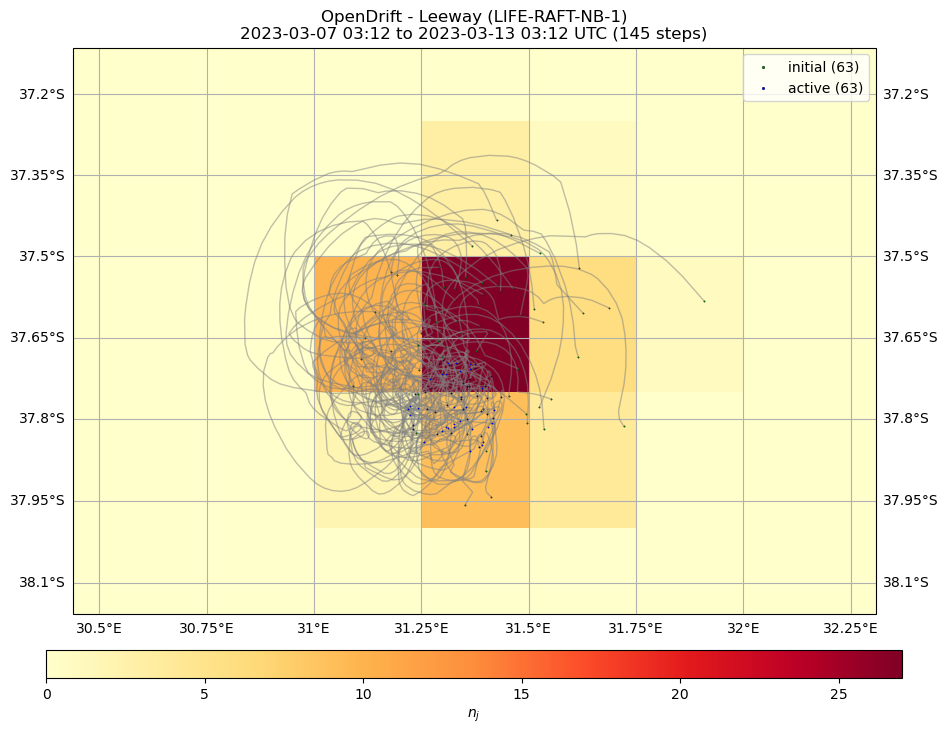

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-07 03:12 to 2023-03-13 03:12 UTC (145 steps)'}>,
 <Figure size 1100x776.423 with 2 Axes>)

In [69]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, cmap='YlOrRd')

In [55]:
outfile_bwd_truth = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_0713mar_raft_capsize_truth_nocurrent_t12s1v3.nc"

In [56]:
orev1 = Leeway(loglevel=50)

10:56:02 DEBUG   opendrift.config:161: Adding 10 config items from environment
10:56:02 DEBUG   opendrift.config:161: Adding 5 config items from environment


In [57]:
orev1 = Leeway(loglevel=50)
orev1.add_reader([reader_wind])

orev1.set_config('drift:advection_scheme', 'runge-kutta4')
orev1.set_config('environment:constant:x_sea_water_velocity', 0)
orev1.set_config('environment:constant:y_sea_water_velocity', 0)

orev1.set_config('capsizing', True)
orev1.set_config('capsizing:wind_threshold',12)
orev1.set_config('capsizing:wind_threshold_sigma', 1)
orev1.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev1.seed_elements(lon=ilon, lat=ilat, radius=10000, radius_type='uniform', number=len(hits.values[0]), time=end_time, object_type=object_type, capsized=1)
orev1.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd_truth)

In [58]:
bwd_truth = xr.open_dataset(outfile_bwd_truth)

In [59]:
capsized_bwd_truth = []
for i in range(len(bwd_truth.trajectory)):
    capsized_bwd_truth.append(bwd_truth.isel(trajectory=i).capsized.values[-1])

In [60]:
np.count_nonzero(capsized_bwd_truth)

0

In [61]:
len(bwd_truth.trajectory)

63

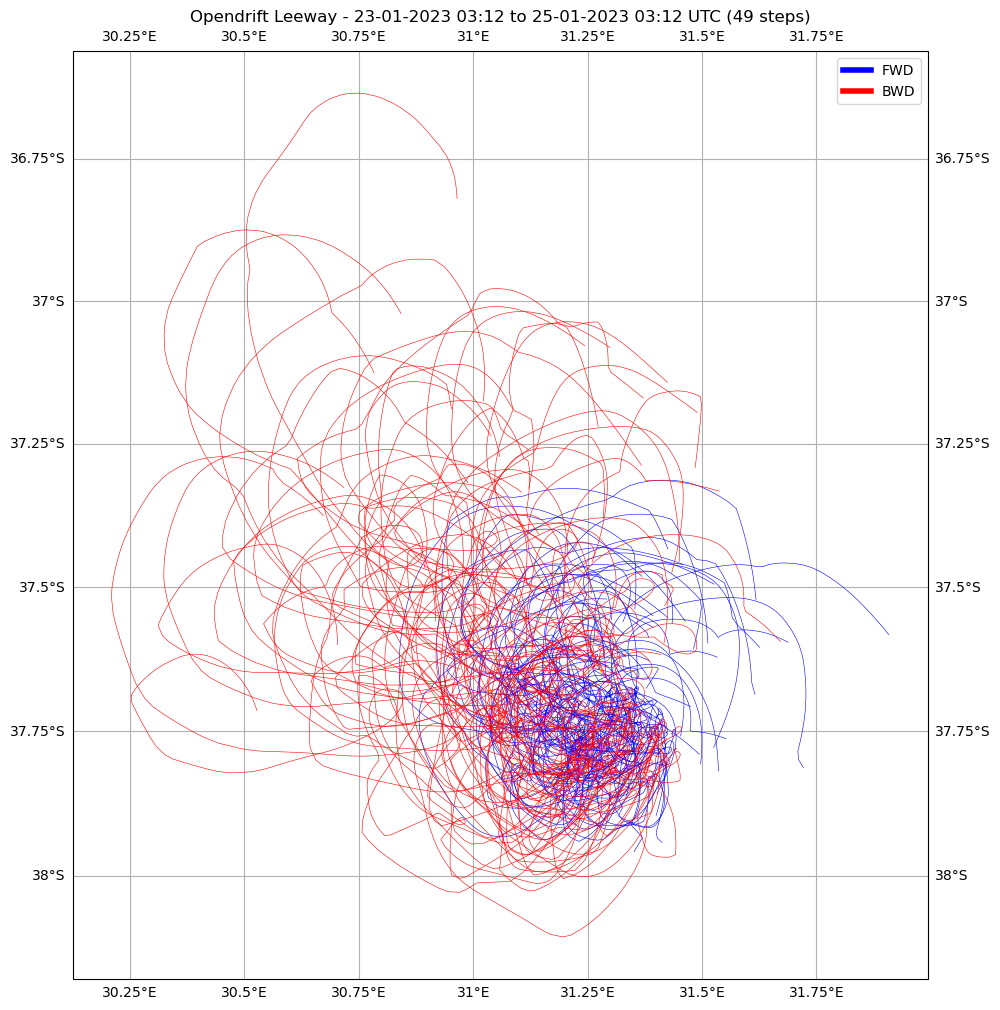

In [62]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [63]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(bwd_truth.trajectory)):
    lonback.append(bwd_truth.isel(trajectory=i).lon.values[-1])
    latback.append(bwd_truth.isel(trajectory=i).lat.values[-1])

In [64]:
### EXTENDED GRID ###

# Set the desired grid size
xgrid_size_lon = 0.25  # Change this to your desired grid size
xgrid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
xlon_bins = np.arange(30, 34, xgrid_size_lon)
xlat_bins = np.arange(-39.5, -36.5, xgrid_size_lat)

In [65]:
grid_counts_back = count_points_in_grid(lonback, latback, xlon_bins, xlat_bins)

In [66]:
o_back = opendrift.open(outfile_bwd_truth)

10:57:11 DEBUG   opendrift.config:161: Adding 16 config items from __init__
10:57:11 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
10:57:11 DEBUG   opendrift.config:161: Adding 5 config items from __init__
10:57:11 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
10:57:11 DEBUG   opendrift.config:161: Adding 6 config items from leeway
10:57:11 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
10:57:11 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_bwd_0713mar_raft_capsize_truth_nocurrent_t12s1v3.nc
10:57:11 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
10:57:11 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_wind -> None
10:57:11 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:fallback:x_wind -> None
10:57:11 DEBUG   opend

10:57:13 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:57:13 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


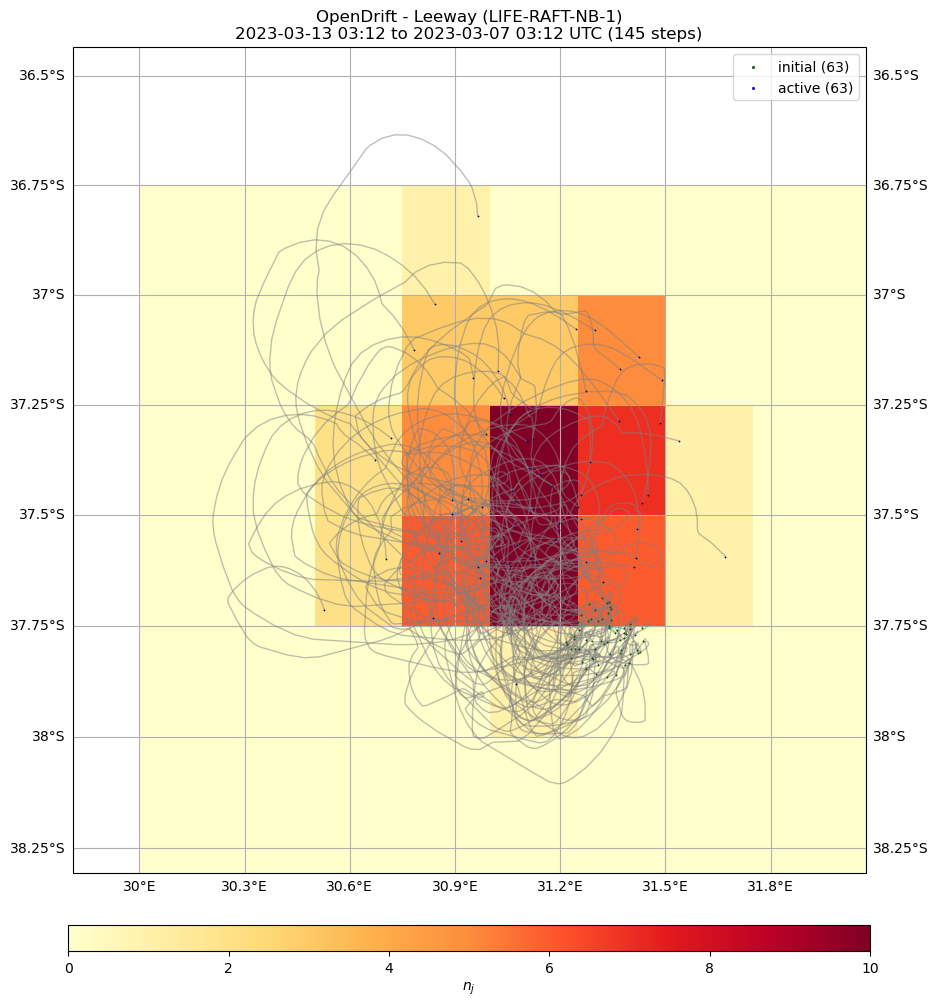

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-13 03:12 to 2023-03-07 03:12 UTC (145 steps)'}>,
 <Figure size 1056.64x1100 with 2 Axes>)

In [67]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, vmin=0, cmap='YlOrRd')

10:57:46 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:57:46 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


<Figure size 640x480 with 0 Axes>

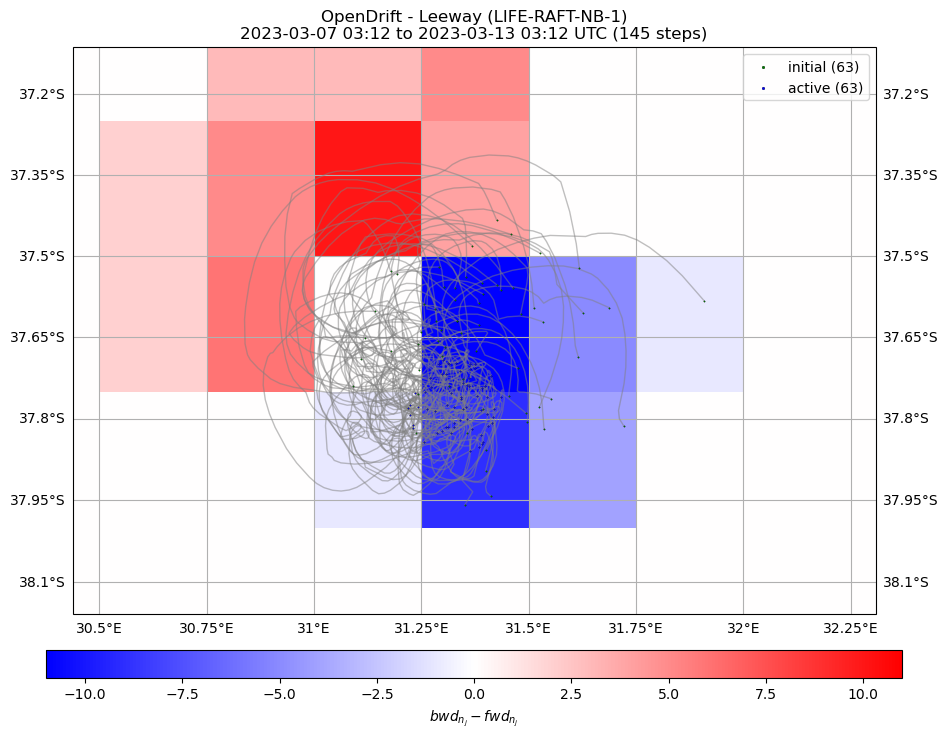

<Figure size 640x480 with 0 Axes>

In [70]:
plt.figure()

o_hit.plot(background=grid_counts_back-grid_counts, clabel='$bwd_{n_j} - fwd_{n_j}$', cmap='bwr', fast=True, markersize=1, lalpha=.5, vmin=-11, vmax=11)

plt.savefig('dif.png') 

In [71]:
dif = grid_counts_back-grid_counts

No time or obs dimension detected.
No time or obs dimension detected.


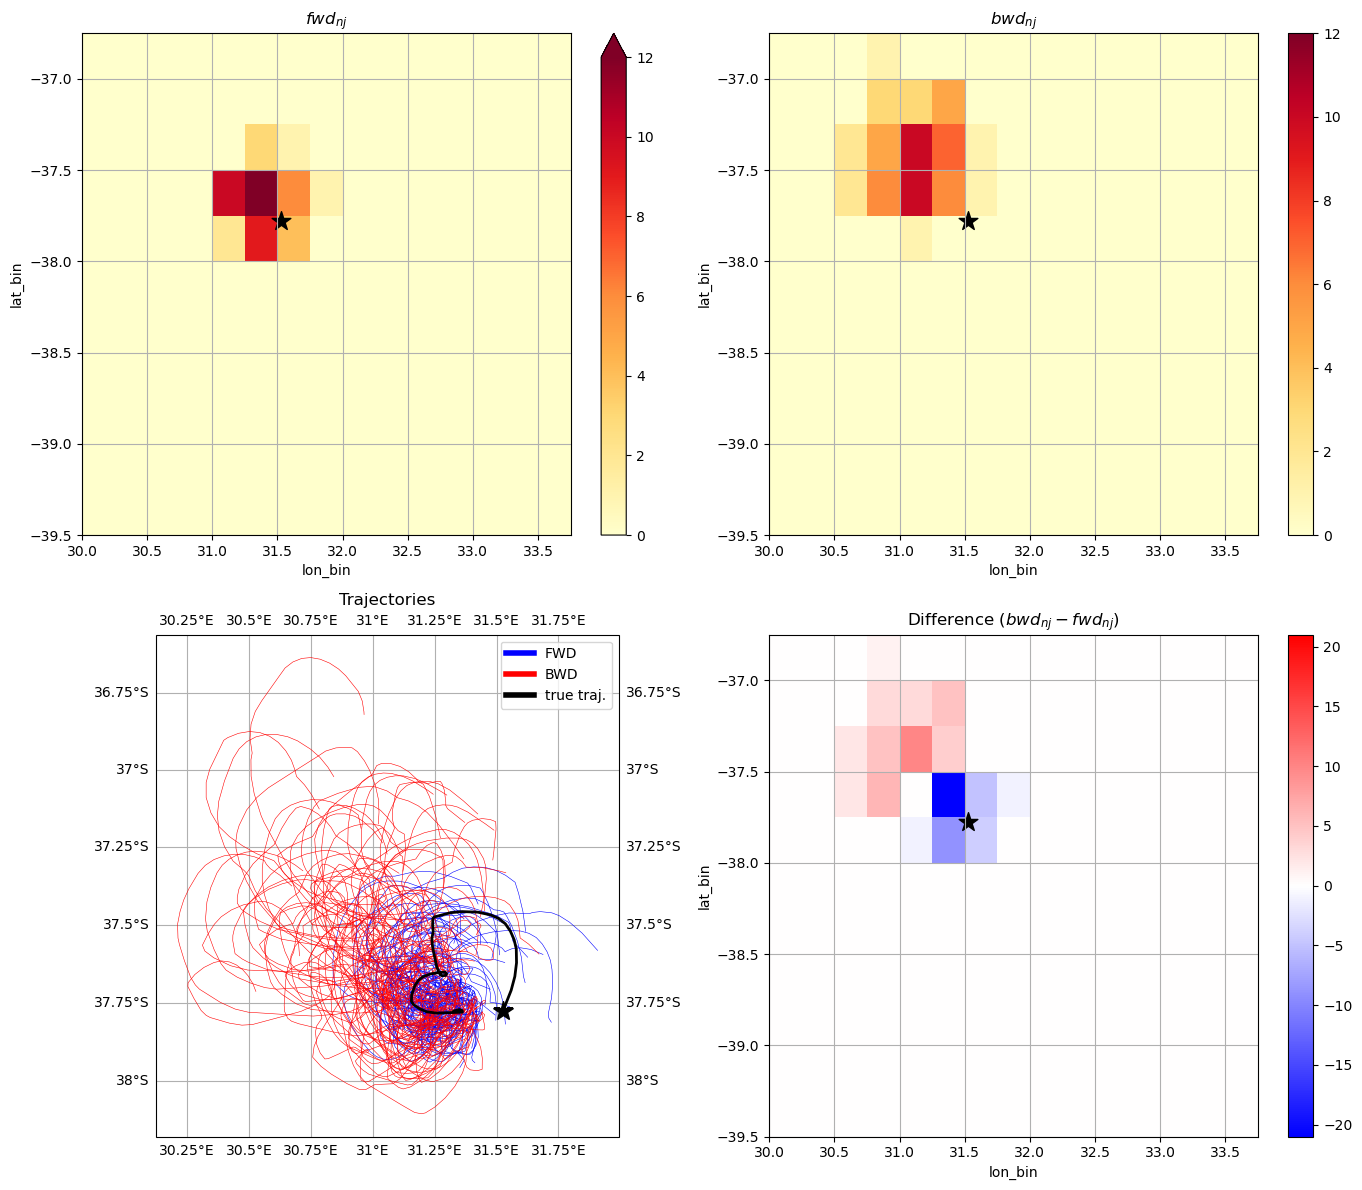

In [72]:
fig = plt.figure(figsize=(14,12))
size=200

plt.subplot(2,2,2)
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], vmax=12, cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='*', color='black')
plt.title('$bwd_{nj}$')
plt.grid()

plt.subplot(2,2,1)
grid_counts.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], vmax=12, cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='*', color='black')
plt.title('$fwd_{nj}$')
plt.grid()

plt.subplot(2,2,4)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='*', color='black')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

# plt.subplot(2,2,3)
ax = fig.add_subplot(223, projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # if capsized_xfwd[i]<1:
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # else: 
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    # if capsized_bwd_truth[i]>0: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='red')
    # else: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
        
fwd.isel(trajectory=a).traj.plot(color='black', linewidth=2)
fwd.isel(trajectory=a).isel(time=0).traj.plot(marker='*', markersize=15, color='black')

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD', 'true traj.'])

# plt.gca().autoscale()
plt.title('Trajectories')

plt.savefig('vierluik_0713mar_thres12_sigma1.pdf') 
plt.show()

No time or obs dimension detected.
No time or obs dimension detected.


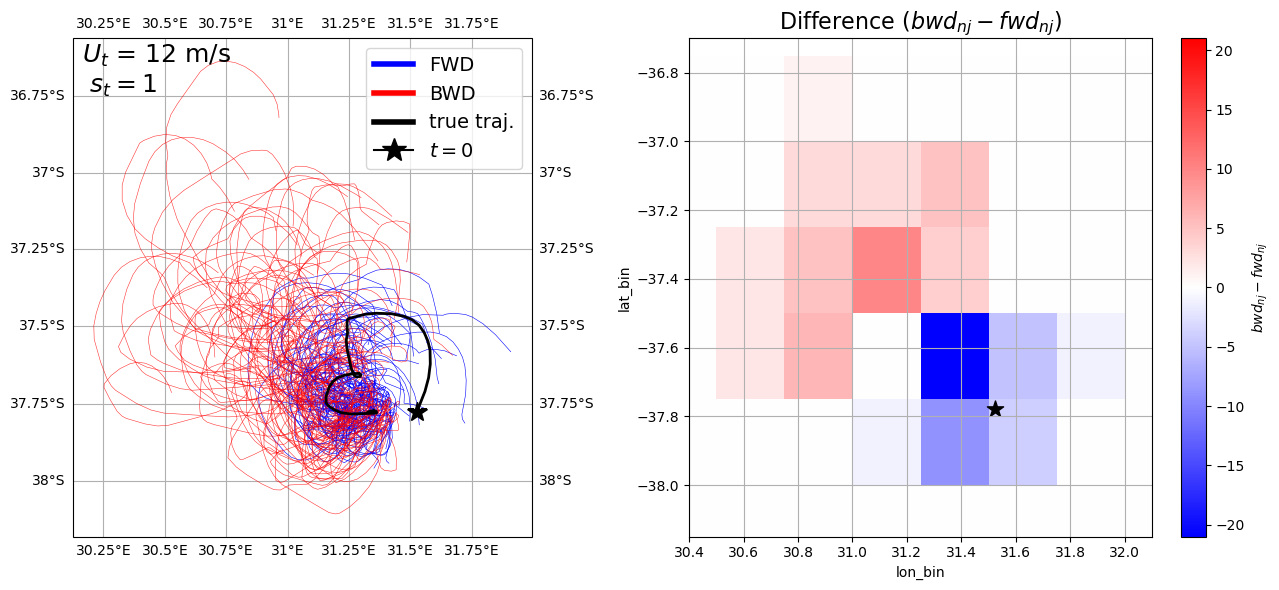

In [138]:
fig = plt.figure(figsize=(13,6))
size=150

plt.subplot(1,2,2)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr',cbar_kwargs={'label':'$bwd_{nj}-fwd_{nj}$'})
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='*', color='black')
plt.xlim([30.4,32.1])
plt.ylim([-38.15,-36.7])
plt.title('Difference $(bwd_{nj}-fwd_{nj})$',fontsize=16)
plt.grid()

# plt.subplot(2,2,3)
ax = fig.add_subplot(121, projection=ccrs.Mercator())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)


for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # if capsized_xfwd[i]<1:
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # else: 
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red', alpha=0.8)
    # if capsized_bwd_truth[i]>0: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='red')
    # else: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
        
fwd.isel(trajectory=a).traj.plot(color='black', linewidth=2)
fwd.isel(trajectory=a).isel(time=0).traj.plot(marker='*', markersize=15, color='black')

# gl = 
# gl.xlabels_top = False
# gl.xlabels_bottom = True
# gl.xlines = True

# gl.ylabels_right = False

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], marker='*', markersize=18, color='black')
               ]

ax.legend(custom_lines, ['FWD', 'BWD', 'true traj.','$t = 0$'], fontsize=14)
plt.title('$U_t$ = 12 m/s \n $s_t = 1$',fontsize=18, x=0.02, y=0.874, ha='left')#pad=-33, loc='left')

plt.savefig('dif_0713mar_thres12_sigma1.pdf')

No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimen

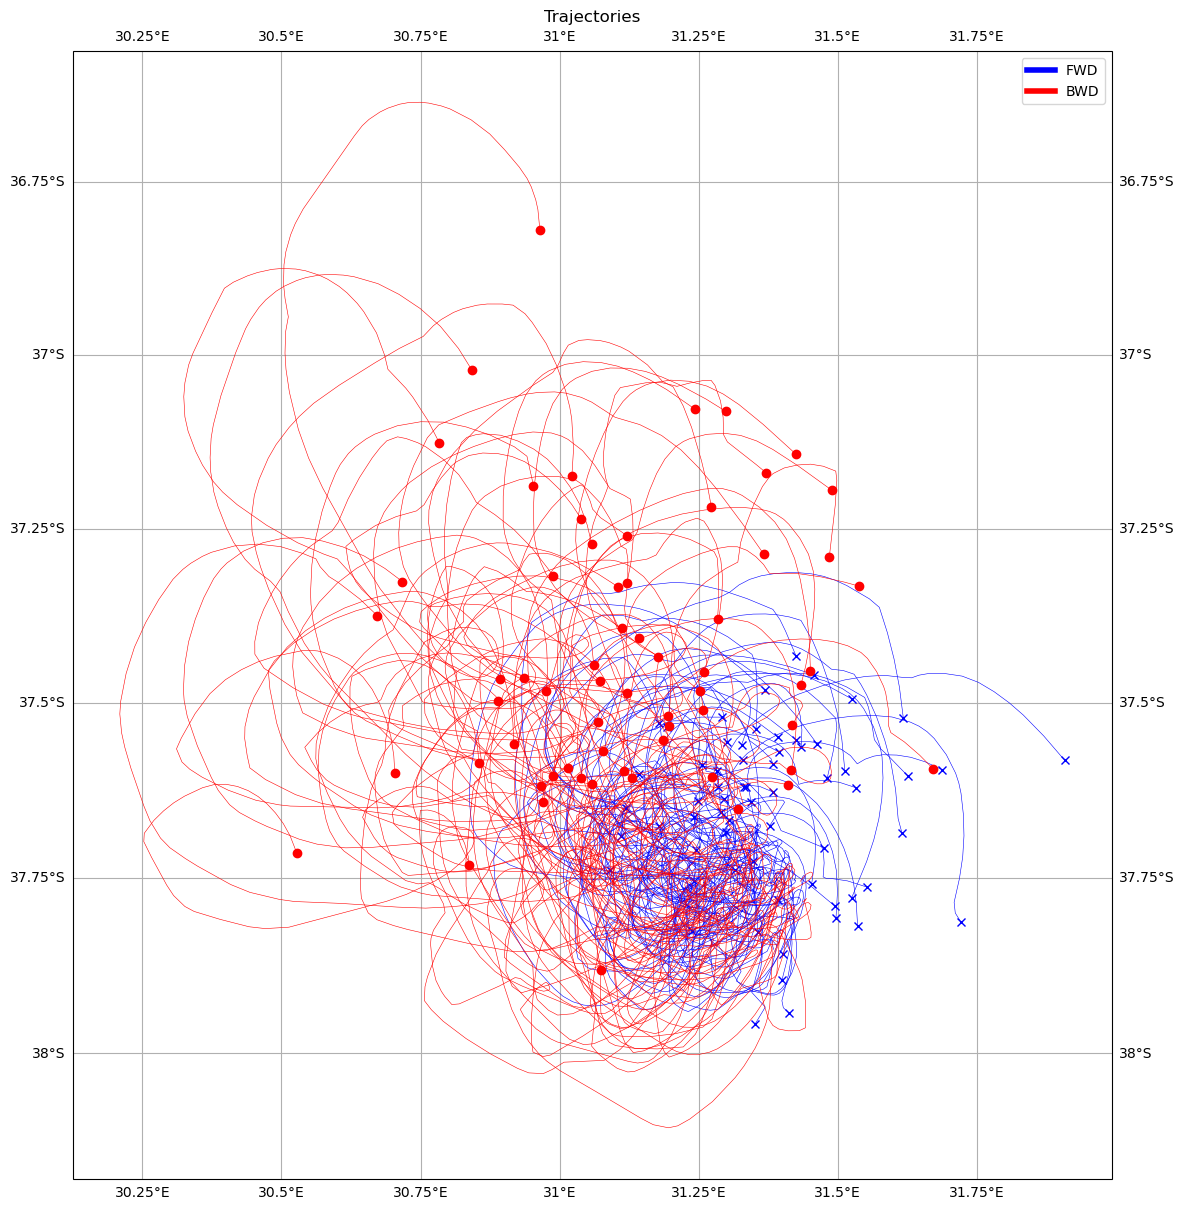

In [112]:
fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    if capsized_xfwd[i]<1:
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='o', color='blue')
    else: 
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='x', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    if capsized_bwd_truth[i]>0: 
        bwd_truth.isel(trajectory=i).isel(time=144).traj.plot(marker='x', color='red')
    else: 
        bwd_truth.isel(trajectory=i).isel(time=144).traj.plot(marker='o', color='red')
        
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
plt.title('Trajectories')
plt.show()

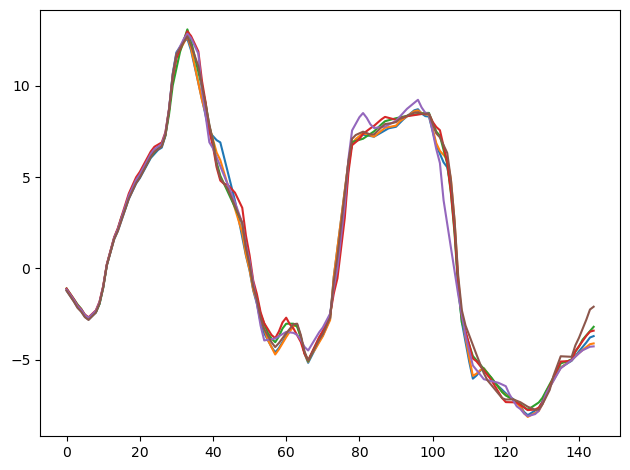

In [113]:
plt.plot(bwd_truth.isel(trajectory=0).x_wind)
plt.plot(bwd_truth.isel(trajectory=5).x_wind)
plt.plot(bwd_truth.isel(trajectory=10).x_wind)
plt.plot(bwd_truth.isel(trajectory=15).x_wind)
plt.plot(bwd_truth.isel(trajectory=20).x_wind)
plt.plot(bwd_truth.isel(trajectory=25).x_wind)

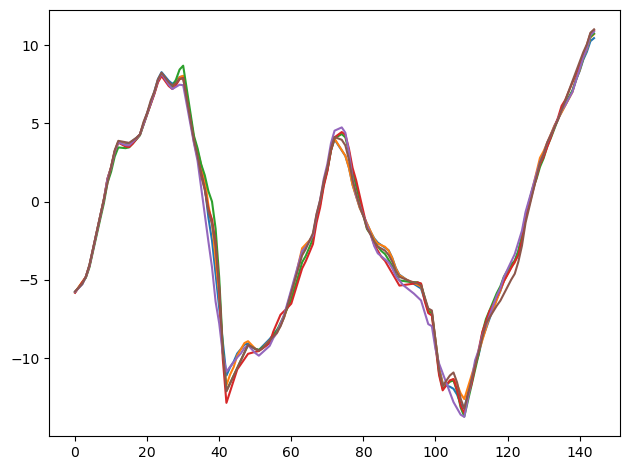

In [114]:
plt.plot(bwd_truth.isel(trajectory=0).y_wind)
plt.plot(bwd_truth.isel(trajectory=5).y_wind)
plt.plot(bwd_truth.isel(trajectory=10).y_wind)
plt.plot(bwd_truth.isel(trajectory=15).y_wind)
plt.plot(bwd_truth.isel(trajectory=20).y_wind)
plt.plot(bwd_truth.isel(trajectory=25).y_wind)

In [115]:
wind = np.sqrt(np.square(fwd.isel(trajectory=a_traj).x_wind.values)+np.square(fwd.isel(trajectory=a_traj).y_wind.values))

Text(0, 0.5, 'wind speed (m/s)')

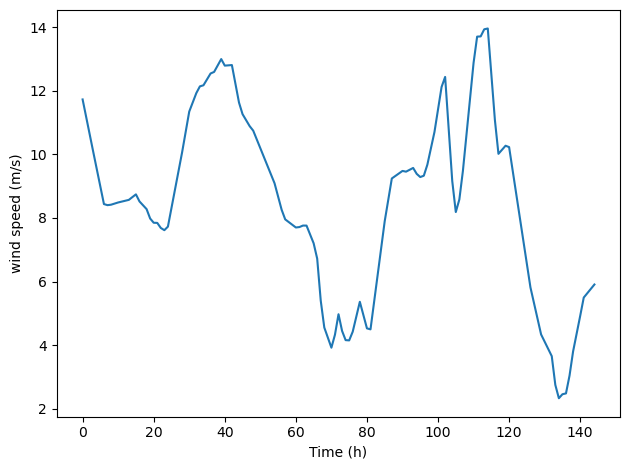

In [116]:
plt.plot(wind[0])
plt.xlabel('Time (h)')
plt.ylabel('wind speed (m/s)')

# plt.savefig('wind_1015jan.png') 

In [117]:
wind_all = []
for i in range(len(xfwd.trajectory)):
    wind_all.append(np.sqrt(np.square(xfwd.isel(trajectory=i).x_wind.values)+np.square(xfwd.isel(trajectory=i).y_wind.values)))

In [118]:
xfwd

<xarray.Dataset> Size: 951kB
Dimensions:               (trajectory: 63, time: 145)
Coordinates:
  * trajectory            (trajectory) int32 252B 3264 3271 3309 ... 4849 5403
  * time                  (time) datetime64[ns] 1kB 2023-03-07T03:12:08 ... 2...
Data variables: (12/23)
    status                (trajectory, time) float64 73kB ...
    moving                (trajectory, time) float64 73kB ...
    age_seconds           (trajectory, time) float32 37kB ...
    origin_marker         (trajectory, time) float64 73kB ...
    lon                   (trajectory, time) float32 37kB ...
    lat                   (trajectory, time) float32 37kB ...
    ...                    ...
    current_drift_factor  (trajectory, time) float32 37kB ...
    x_wind                (trajectory, time) float32 37kB ...
    y_wind                (trajectory, time) float32 37kB ...
    x_sea_water_velocity  (trajectory, time) float32 37kB ...
    y_sea_water_velocity  (trajectory, time) float32 37kB ...
    land_binary_mask      (trajectory, time) float32 37kB ...
Attributes: (12/72)
    Conventions:                                       CF-1.6
    standard_name_vocabulary:                          CF-1.6
    featureType:                                       trajectory
    history:                                           Created 2024-05-31 17:...
    source:                                            Output from simulation...
    model_url:                                         https://github.com/Ope...
    ...                                                ...
    geospatial_lat_resolution:                         point
    geospatial_lon_min:                                0.0
    geospatial_lon_max:                                0.0
    geospatial_lon_units:                              degrees_east
    geospatial_lon_resolution:                         point
    runtime:                                           0:00:35.551077

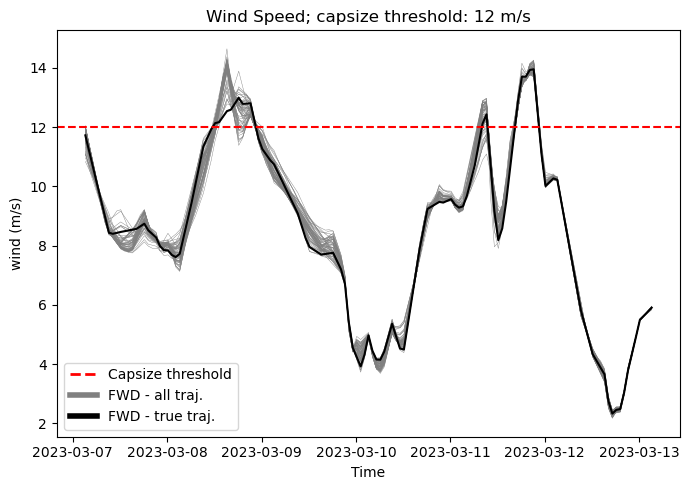

In [120]:
plt.figure(figsize=(7,5))

for i in range(len(xfwd.trajectory)):
    plt.plot(xfwd.time.values, wind_all[i], color='grey',linewidth=0.3)

plt.plot(xfwd.time.values, wind[0], color='black')
plt.axhline(y=12, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('wind (m/s)')
# plt.xticks(rotation=20)

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=2, linestyle='--'),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

plt.legend(custom_lines, ['Capsize threshold', 'FWD - all traj.', 'FWD - true traj.'])
plt.title('Wind Speed; capsize threshold: 12 m/s')

plt.savefig('wind_0713mar_thres12_sigma1.pdf')

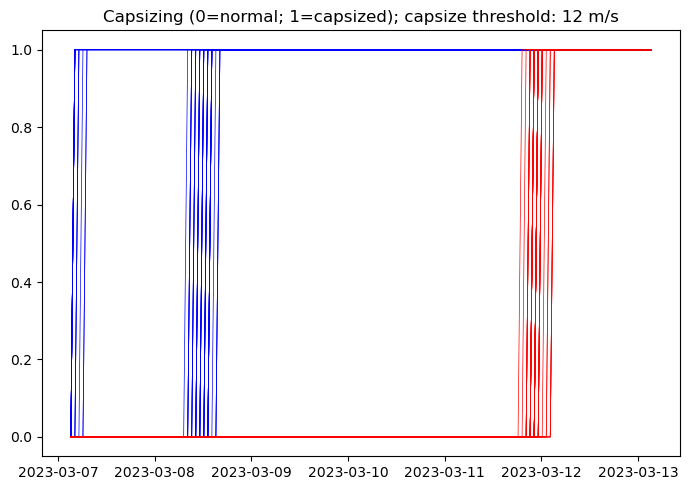

In [121]:
plt.figure(figsize=(7,5))

for i in range(len(xfwd.trajectory)):
    plt.plot(xfwd.time.values, xfwd.isel(trajectory=i).capsized.values, color='blue',linewidth=0.5)

for i in range(len(bwd_truth.trajectory)):
    plt.plot(bwd_truth.time.values, bwd_truth.isel(trajectory=i).capsized.values, color='red',linewidth=0.5)

plt.title('Capsizing (0=normal; 1=capsized); capsize threshold: 12 m/s')

plt.savefig('capsizing_0713mar_thres12_sigma1.pdf')

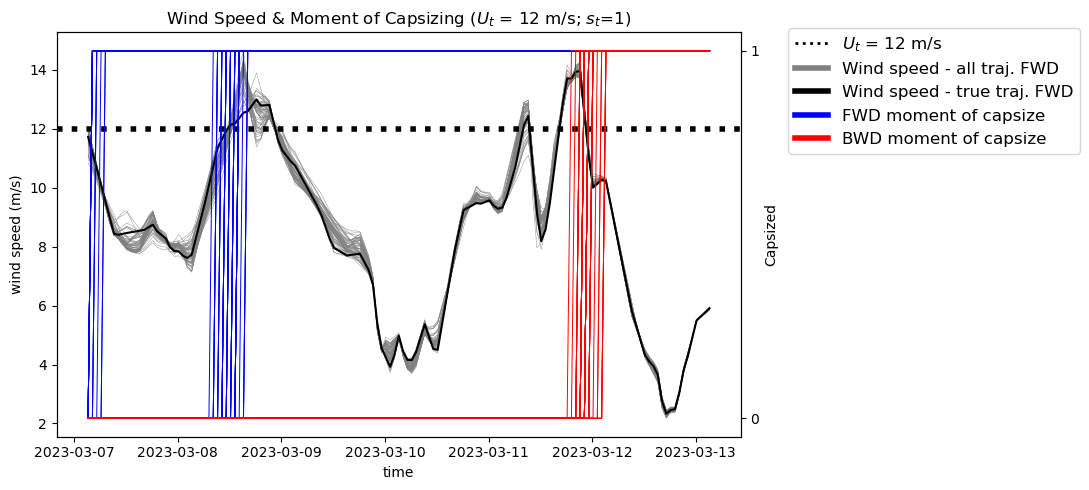

In [132]:
fig, ax1 = plt.subplots(figsize=(11,5))



ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('Capsized', color=color)  # we already handled the x-label with ax1

for i in range(len(xfwd.trajectory)):
    ax2.plot(xfwd.time.values, xfwd.isel(trajectory=i).capsized.values, color='blue',linewidth=0.7)

for i in range(len(bwd_truth.trajectory)):
    ax2.plot(bwd_truth.time.values, bwd_truth.isel(trajectory=i).capsized.values, color='red',linewidth=0.7)

# ax2.title('Capsizing (0=normal; 1=capsized); capsize threshold: 12 m/s')

ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_ticks(np.arange(0, 2, 1))

color = 'black'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Wind speed (m/s)', color=color)


for i in range(len(xfwd.trajectory)):
    ax1.plot(xfwd.time.values, wind_all[i], color='grey',linewidth=0.3)

ax1.plot(xfwd.time.values, wind[0], color='black')
ax1.axhline(y=12, color='black', linestyle=':',linewidth=4)
ax1.set_xlabel('time')
ax1.set_ylabel('wind speed (m/s)')
# ax1.set_ylim([0,22])
# plt.xticks(rotation=20)

custom_lines = [Line2D([0], [0], color='black', lw=2, linestyle=':'),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)
               ]

ax1.legend(custom_lines, ['$U_t$ = 12 m/s', 'Wind speed - all traj. FWD', 'Wind speed - true traj. FWD','FWD moment of capsize', 'BWD moment of capsize'], loc=(1.07,0.70), fontsize=12)
ax1.set_title('Wind Speed & Moment of Capsizing ($U_t$ = 12 m/s; $s_t$=1)', fontsize=12)
#(1.07,0.70)
ax1.tick_params(axis='y', labelcolor=color)

plt.savefig('wind_and_capsizing_0713mar_thres12_sigma1.pdf')

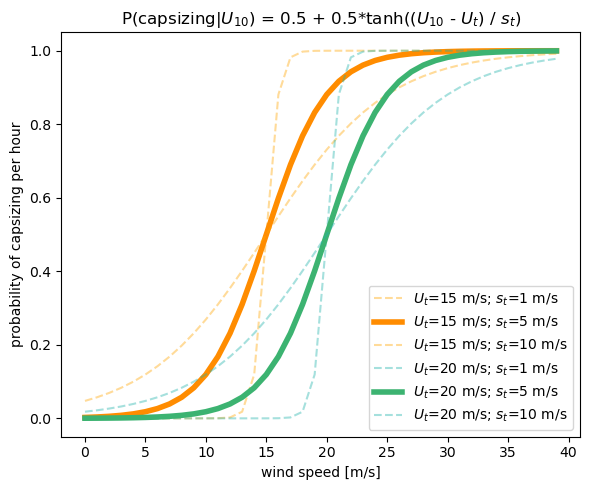

In [143]:
windspeed = np.arange(0,40,1)
plt.figure(figsize=(6,5))

plt.plot(0.5 + 0.5*np.tanh((windspeed-15)/1), '--', color='orange', label='$U_t$=15 m/s; $s_t$=1 m/s',alpha=0.4)
plt.plot(0.5 + 0.5*np.tanh((windspeed-15)/5), color='darkorange', label='$U_t$=15 m/s; $s_t$=5 m/s', linewidth=4)
plt.plot(0.5 + 0.5*np.tanh((windspeed-15)/10), '--', color='orange', label='$U_t$=15 m/s; $s_t$=10 m/s',alpha=0.4)

plt.plot(0.5 + 0.5*np.tanh((windspeed-20)/1), '--', color='lightseagreen', label='$U_t$=20 m/s; $s_t$=1 m/s',alpha=0.4)
plt.plot(0.5 + 0.5*np.tanh((windspeed-20)/5), color='mediumseagreen', label='$U_t$=20 m/s; $s_t$=5 m/s', linewidth=4)
plt.plot(0.5 + 0.5*np.tanh((windspeed-20)/10), '--', color='lightseagreen', label='$U_t$=20 m/s; $s_t$=10 m/s',alpha=0.4)

plt.legend(loc='lower right')
plt.title('P(capsizing|$U_{10}$) = 0.5 + 0.5*tanh(($U_{10}$ - $U_t$) / $s_t$)')
plt.xlabel('wind speed [m/s]')
plt.ylabel('probability of capsizing per hour')

plt.savefig('probability_of_capsizing_0713mar_thres12_sigma1.pdf')